In [32]:
using LinearAlgebra
using Distributed
using SharedArrays
using Plots
using DataFrames, CSV
using Revise

In [33]:
using BeyondHulten

## Loading in Data

In [34]:
data = read_data("I-O_DE2019_formatiert.csv")

Data(84×87 DataFrame
 Row │ Sektoren                           Erz. d. Landwirtschaft, Jagd und Die ⋯
     │ String                             Int64                                ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Erz. d. Landwirtschaft, Jagd und…                                       ⋯
   2 │ Forstwirtschaftl. Erzeugnisse un…
   3 │ Fische, Fischerei- und Aquakultu…
   4 │ Kohle
   5 │ Erdöl und Erdgas                                                        ⋯
   6 │ Erze, Steine und Erden, sonstige…
   7 │ Nahrungs- u. Futtermittel, Geträ…
   8 │ Textilien, Bekleidung, Leder und…
  ⋮  │                 ⋮                                          ⋮            ⋱
  78 │ Bruttolöhne und -gehälter                                               ⋯
  79 │ Sonst.Produktionsabgaben abzgl. …
  80 │ Abschreibungen
  81 │ Nettobetriebsüberschuss
  82 │ Bruttowertschöpfung                                                     ⋯
  83 │ Produktionsw

## Setting Elasticities

Es können verschiedene Elastizitäten gesetzt werden, die hier verwendeten sind übernommen aus B&F 2019 
(el. of substitiution of inermediates = 0.0001, el labor/intermediates  = 0.5 el. of consumption = 0.9)

In [37]:
elasticities = CESElasticities(0.001,0.5,0.9)

MethodError: MethodError: no method matching CESELasticities(::Float64, ::Float64, ::Float64)

## Setting Shocks

Shocks können entweder mit `calculate_investment!` in  1000€ eingegeben werden, oder die einzelnen Elemente im Vektor können auch direkt verändernt werden (z.b `supply_shock[12] = 1.2`), was dann einem Anstieg an demand von 20% entsrpicht.

In [5]:
demand_shock = ones(71)
supply_shock = ones(71)
shocks = Shocks(supply_shock, demand_shock)
shocks.supply_shock[1] = 0.9
#sector = ["Vorb.Baustellen-,Bauinstallations-,Ausbauarbeiten"]
#investment = [25000]
#calculate_investment!(shocks, data, investment, sector)

0.9

## Full labor reallocation

In [6]:
model = Model(data, shocks, elasticities)
solution = solve(model)

71×7 DataFrame
 Row │ prices    quantities   sectors                            value_added_a ⋯
     │ Float64   Float64      String                             Float64       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 1.26767   0.0166847    Erz. d. Landwirtschaft, Jagd und…           107. ⋯
   2 │ 0.997821  0.00221356   Forstwirtschaftl. Erzeugnisse un…             4.
   3 │ 1.01416   0.00016062   Fische, Fischerei- und Aquakultu…             0.
   4 │ 0.998026  0.000964668  Kohle                                         0.
   5 │ 0.998015  0.000486604  Erdöl und Erdgas                              0. ⋯
   6 │ 0.997679  0.00467057   Erze, Steine und Erden, sonstige…             7.
   7 │ 1.03828   0.0646527    Nahrungs- u. Futtermittel, Geträ…           601.
   8 │ 0.993502  0.00742362   Textilien, Bekleidung, Leder und…            14.
  ⋮  │    ⋮           ⋮                       ⋮                           ⋮    ⋱
  65 │ 0.997242  0.0776392    Dienstleistungen des Gesundheits…          8459. ⋯
  66 │ 0.99723   0.0349536    Dienstleistungen von Heimen und …          1569.
  67 │ 0.997154  0.0113832    Dienstleist. der Kunst, Kultur u…           162.
  68 │ 0.997714  0.00980877   DL des Sports, der Unterhaltung …           102.
  69 │ 0.998442  0.0143477    DL d. Interessenvertr., kirchl. …           320. ⋯
  70 │ 0.99713   0.00143466   Reparaturarbeiten an DV-Geräten …             2.
  71 │ 0.997048  0.0178858    Sonstige überwiegend persönliche…           448.
                                                   4 columns and 56 rows omitted

In [7]:
println("Real GDP: $(real_gdp(solution,relative=true))")
println("Nominal GDP: $(nominal_gdp(solution,relative=true))")


Real GDP: 0.9982621561985534
Nominal GDP: 0.9979648301377121


## No labor reallocation 

Es können verschiedene Funktionen angegeben werden,die zurückgeben wie viel Arbeit in den einzelnen Sektoren verfügbar. Hier in diesem Fall, ist keine zusätzliche Arbeit verfügbar, die funktion könnte aber auch zum Beispiel so aussehen: 
```julia
labor_realloc(data) = min(1.05 * data.labor_share,inv(I - diagm(1 .- data.factor_share) * data.Ω) * (data.consumption_share_gross_output .* ((data.shocks.demand_shock .* data.labor_share) - data.labor_share)) + data.labor_share)
``` 
(maximal 5% der verfügbaren Arbeit kann zusätzlich verwendet werden um der gesteigerten Nachfrage nachzukommen)

In [8]:
labor_realloc(model) = model.data.labor_share #no labor_reallocation

labor_realloc (generic function with 1 method)

In [9]:
sol = solve(model, labor_reallocation=labor_realloc)

71×7 DataFrame
 Row │ prices    quantities   sectors                            value_added_a ⋯
     │ Float64   Float64      String                             Float64       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 1.26767   0.0166847    Erz. d. Landwirtschaft, Jagd und…           107. ⋯
   2 │ 0.997821  0.00221356   Forstwirtschaftl. Erzeugnisse un…             4.
   3 │ 1.01416   0.00016062   Fische, Fischerei- und Aquakultu…             0.
   4 │ 0.998026  0.000964668  Kohle                                         0.
   5 │ 0.998015  0.000486604  Erdöl und Erdgas                              0. ⋯
   6 │ 0.997679  0.00467057   Erze, Steine und Erden, sonstige…             7.
   7 │ 1.03828   0.0646527    Nahrungs- u. Futtermittel, Geträ…           601.
   8 │ 0.993502  0.00742362   Textilien, Bekleidung, Leder und…            14.
  ⋮  │    ⋮           ⋮                       ⋮                           ⋮    ⋱
  65 │ 0.997242  0.0776392    Dienstleistungen des Gesundheits…          8459. ⋯
  66 │ 0.99723   0.0349536    Dienstleistungen von Heimen und …          1569.
  67 │ 0.997154  0.0113832    Dienstleist. der Kunst, Kultur u…           162.
  68 │ 0.997714  0.00980877   DL des Sports, der Unterhaltung …           102.
  69 │ 0.998442  0.0143477    DL d. Interessenvertr., kirchl. …           320. ⋯
  70 │ 0.99713   0.00143466   Reparaturarbeiten an DV-Geräten …             2.
  71 │ 0.997048  0.0178858    Sonstige überwiegend persönliche…           448.
                                                   4 columns and 56 rows omitted

In [10]:
println("Real GDP: $(real_gdp(sol,relative=false))")
println("Nominal GDP: $(nominal_gdp(sol,relative=false))")

Real GDP: 110067.42972097699
Nominal GDP: 109852.38603125047


## Progressive Sector Shocks
Shock every sector and look at difference in impacts (output see the 4 demand_shock csv files: nominal, real, labor reallocation, no labor reallocation):

Sets the amount and range of shocks

In [11]:
min_shock = 1.0
max_shock = 1.8
shock_count = 50

50

Shocks each sector from `min_shock` to `max_shock` in `amount` stepsand returns a matrix containing the resulting GDP of each shock

In [12]:
function progressive_shocks(data, min_shock, max_shock, amount, GDP_function, labor_reallocation_function)
    GDP = SharedArray(zeros(length(data.labor_share), amount))
    shock_values = LinRange(min_shock, max_shock, amount)
    supply_shock = SharedArray(ones(71))


    @distributed for i in 1:71
        init = Complex.([ones(71)..., data.λ...])
        demand_shock = ones(71)
        for (k, shock_value) in enumerate(shock_values)
            demand_shock[i] = shock_value
            shock = Shocks(supply_shock, demand_shock)
            model = Model(data, shock, elasticities)
            sol = solve(model, init=init, labor_reallocation=labor_reallocation_function)
            GDP[i, k] = GDP_function(sol)
            #take solutions from before as init values, since solution from next run should be close 
            # to soultion from previous (comlex turns the real values back into complex number to allow for solution)
            init = Complex.([sol.prices..., sol.quantities...])
        end
    end
    return GDP
end

progressive_shocks (generic function with 1 method)

In [13]:
GDP_nominal = progressive_shocks(data, min_shock, max_shock, shock_count, nominal_gdp, full_demand_labor_allocation)
GDP_no_realloc_nominal = progressive_shocks(data, min_shock, max_shock, shock_count, nominal_gdp, labor_realloc)
GDP = progressive_shocks(data, min_shock, max_shock, shock_count, real_gdp, full_demand_labor_allocation)
GDP_no_realloc = progressive_shocks(data, min_shock, max_shock, shock_count, real_gdp, labor_realloc)

71×50 SharedMatrix{Float64}:
 1.0  1.00001   1.00001   1.00002   1.00002   …  0.999825  0.999812  0.999799
 1.0  1.0       1.00001   1.00001   1.00001      1.00005   1.00005   1.00005
 1.0  1.0       1.0       1.0       1.0          1.0       1.0       1.0
 1.0  1.0       1.0       1.00001   1.00001      1.00006   1.00006   1.00006
 1.0  1.0       1.0       1.0       1.0          1.00003   1.00003   1.00003
 1.0  1.00001   1.00001   1.00002   1.00003   …  1.00023   1.00023   1.00024
 1.0  0.999984  0.999967  0.99995   0.999932     0.998942  0.998914  0.998885
 1.0  0.99999   0.99998   0.99997   0.99996      0.999431  0.999417  0.999403
 1.0  1.0       1.00001   1.00001   1.00002      1.00015   1.00016   1.00016
 1.0  1.00001   1.00003   1.00004   1.00005      1.00037   1.00037   1.00038
 ⋮                                            ⋱                      
 1.0  1.00002   1.00004   1.00006   1.00008      1.00029   1.00028   1.00028
 1.0  0.999987  0.999971  0.999952  0.99993      0.9973

Saves the caluclated results as CSV. Each Row contains the effect on GDP, when shocking a sector from 1.0 to 1.8 

In [14]:
function savetabular(filname, gdp)
    sectors = data.io.Sektoren[1:71]
    df = DataFrame(gdp[1:end, :]', sectors)
    df[:, :DemandShockAmount] = collect(LinRange(min_shock, max_shock, shock_count))
    CSV.write(joinpath(pwd(), "data", filname), df)
end

savetabular (generic function with 1 method)

In [15]:

savetabular("demand_shock_nominal.csv", GDP_nominal)
savetabular("demand_shock_nominal_no_realloc.csv", GDP_no_realloc_nominal)
savetabular("demand_shock.csv", GDP)
savetabular("demand_shock_no_realloc.csv", GDP_no_realloc)

"/home/franzs/Schreibtisch/BeyondHulten/data/demand_shock_no_realloc.csv"

In [16]:
GDP_no_realloc_nominal

71×50 SharedMatrix{Float64}:
 1.0  0.999001  0.998002  0.997004  0.996006  …  0.953495  0.952517  0.95154
 1.0  0.999789  0.999578  0.999367  0.999155     0.989882  0.989663  0.989444
 1.0  0.999989  0.999978  0.999968  0.999957     0.999486  0.999475  0.999463
 1.0  0.999923  0.999845  0.999768  0.999691     0.996322  0.996242  0.996163
 1.0  0.999949  0.999897  0.999846  0.999795     0.997543  0.99749   0.997437
 1.0  0.999668  0.999337  0.999005  0.998673  …  0.984331  0.983996  0.983662
 1.0  0.998699  0.9974    0.996102  0.994805     0.940287  0.939048  0.937811
 1.0  0.999773  0.999546  0.999319  0.999091     0.989194  0.988962  0.988729
 1.0  0.99965   0.999299  0.998948  0.998598     0.983491  0.983139  0.982788
 1.0  0.999102  0.998204  0.997306  0.996409     0.958102  0.957219  0.956336
 ⋮                                            ⋱                      
 1.0  0.998528  0.997057  0.995586  0.994116     0.931667  0.930238  0.92881
 1.0  0.992878  0.985801  0.978768  0.97178  

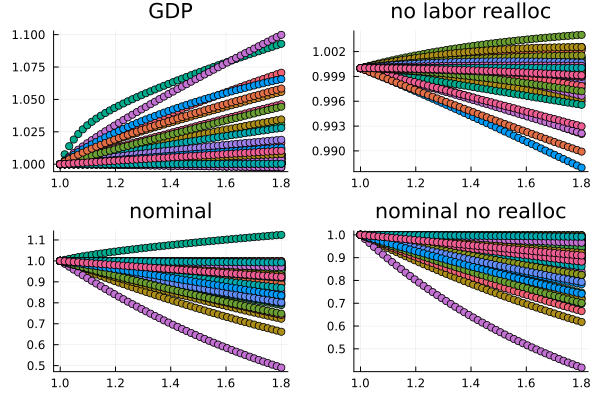

In [17]:
l = @layout [a b; c d]

p1 = Plots.scatter(LinRange(min_shock, max_shock, shock_count), eachrow(GDP), labels="", title="GDP")
p2 = Plots.scatter(LinRange(min_shock, max_shock, shock_count), eachrow(GDP_no_realloc), labels="", title="no labor realloc")
p3 = Plots.scatter(LinRange(min_shock, max_shock, shock_count), eachrow(GDP_nominal), labels="", title="nominal")
p4 = Plots.scatter(LinRange(min_shock, max_shock, shock_count), eachrow(GDP_no_realloc_nominal), labels="", title="nominal no realloc")
Plots.plot(p1, p2, p3, p4, layout=l)

In [18]:
Plots.savefig("plots/shock_plots.png")

"/home/franzs/Schreibtisch/BeyondHulten/plots/shock_plots.png"

## Wertschöpfung pro Sektor

In [19]:
# Sample shock
demand_shock = ones(71)
supply_shock = ones(71)
shocks = Shocks(supply_shock, demand_shock)
#shocks.demand_shock[35] = 1.09
#sector = ["Vorb.Baustellen-,Bauinstallations-,Ausbauarbeiten", "Keramik, bearbeitete Steine und Erden"]
#investment = [25000, 1000]
sector = ["Vorb.Baustellen-,Bauinstallations-,Ausbauarbeiten"]
investment = [25000]
calculate_investment!(shocks, data, investment, sector)

Demand shock to sector Vorb.Baustellen-,Bauinstallations-,Ausbauarbeiten: 1.2048978788971576


In [20]:
model = Model(data, shocks, elasticities)
sol = solve(model)

71×7 DataFrame
 Row │ prices    quantities   sectors                            value_added_a ⋯
     │ Float64   Float64      String                             Float64       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.941467  0.0178228    Erz. d. Landwirtschaft, Jagd und…          109.6 ⋯
   2 │ 0.685661  0.00269808   Forstwirtschaftl. Erzeugnisse un…            5.4
   3 │ 0.624475  0.000192399  Fische, Fischerei- und Aquakultu…            0.0
   4 │ 0.798861  0.00104851   Kohle                                        0.4
   5 │ 0.725659  0.000570805  Erdöl und Erdgas                             0.2 ⋯
   6 │ 0.798131  0.00505099   Erze, Steine und Erden, sonstige…            7.1
   7 │ 0.941349  0.0645904    Nahrungs- u. Futtermittel, Geträ…          598.1
   8 │ 0.840017  0.00763558   Textilien, Bekleidung, Leder und…           13.8
  ⋮  │    ⋮           ⋮                       ⋮                           ⋮    ⋱
  65 │ 0.944702  0.0776246    Dienstleistungen des Gesundheits…         8456.0 ⋯
  66 │ 0.957351  0.0349536    Dienstleistungen von Heimen und …         1569.2
  67 │ 0.938483  0.0114284    Dienstleist. der Kunst, Kultur u…          163.7
  68 │ 0.935784  0.00985931   DL des Sports, der Unterhaltung …          102.9
  69 │ 0.926766  0.0145172    DL d. Interessenvertr., kirchl. …          324.3 ⋯
  70 │ 0.865151  0.00151355   Reparaturarbeiten an DV-Geräten …            2.7
  71 │ 0.937752  0.0179305    Sonstige überwiegend persönliche…          450.1
                                                   4 columns and 56 rows omitted

value_added is a a 71 element vector, whos i-th element is the value added in sector i

Look at sectoral value added:

In [21]:
print(sol[:, ["value_added_nominal_relative", "value_added_relative"]] .- data.labor_share)

71×2 DataFrame
 Row │ value_added_nominal_relative  value_added_relative 
     │ Float64                       Float64              
─────┼────────────────────────────────────────────────────
   1 │                 -0.000305818           4.77483e-5
   2 │                 -0.000229614           0.000227917
   3 │                 -3.04409e-5           -1.22027e-5
   4 │                 -8.85237e-5           -1.13573e-5
   5 │                 -6.15295e-5            1.65964e-5
   6 │                 -0.00033251           -2.50852e-5
   7 │                 -0.000645278           0.000184545
   8 │                 -0.000403988          -6.77341e-5
   9 │                 -0.000876694          -0.000388327
  10 │                 -0.000306312           1.49341e-5
  11 │                 -0.000184372           7.77182e-6
  12 │                 -0.000299441          -0.000232968
  13 │                 -0.00102394            0.000169347
  14 │                  3.99582e-5            4.76639e-5
  15 

Calculate inflation via GDP deflator:

In [22]:
deflator = sum(sol.value_added_nominal_relative) / sum(sol.value_added_relative)
println("GDP deflator: $(deflator)")
inflation_rate = (deflator - 1) / 1 #since initially the GDP deflator is 1 as we use pre-shock prices for value added and value added nominal
println("inflation rate: $(inflation_rate)")

GDP deflator: 0.933687970123541
inflation rate: -0.06631202987645901


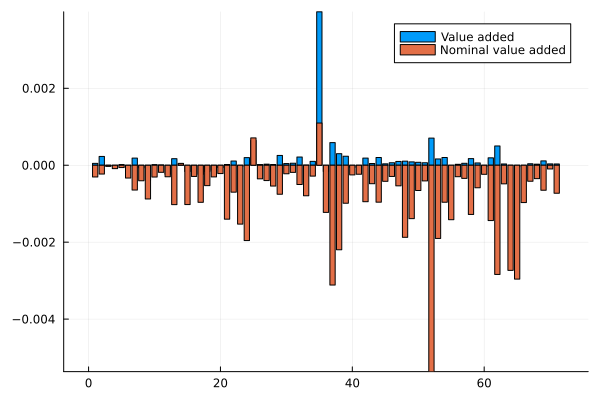

In [27]:
bar(1:71, [sol.value_added_relative - data.labor_share, sol.value_added_nominal_relative - data.labor_share], label=["Value added" "Nominal value added"])

In [24]:
Plots.savefig("plots/sector_effects.png")

"/home/franzs/Schreibtisch/BeyondHulten/plots/sector_effects.png"

In [29]:
elasticities = CESElasticities(0.001,0.5,0.9)

UndefVarError: UndefVarError: `CESElasticities` not defined

UndefVarError: UndefVarError: `CESElasticities` not defined